In [5]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import wandb
import matplotlib.pyplot as plt
import warnings
import torch.nn.functional as F
from torchvision.transforms.functional import center_crop
import matplotlib.pyplot as plt



from dataset import LandcoverDataset, class_names, class_labels
from model import Unet
from utils import label_to_onehot, count_classes

warnings.simplefilter(action="ignore")

ModuleNotFoundError: No module named 'dataset'

In [14]:
wandb.login(key="5f5a6e6618ddafd57c6c7b40a8313449bfd7a04e")
wandb.init(
    project="landcover-segmentation",
    group="test-preactivations-hook"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/david/.netrc


**Nota**: Ya puedo loggear las (pre)activaciones de una capa en 

In [3]:
# reproducibility
torch.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
wandb_log = True
# data
resize_res = 512
batch_size = 1
epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
def double_conv(in_channels, out_channels):
    """3x3Conv -> ReLU -> 3x3Conv ->ReLU"""
    conv = nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            bias=True,
            padding=1,
        ),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            bias=True,
            padding=1,
        ),
        nn.ReLU(inplace=True),
    )
    return conv


class Kaimming_Unet(nn.Module):
    """Vanilla UNet architecture from the original paper"""

    def __init__(self):
        super().__init__()
        self.dconv1 = double_conv(in_channels=3, out_channels=64)
        self.dconv2 = double_conv(in_channels=64, out_channels=128)
        self.dconv3 = double_conv(in_channels=128, out_channels=256)
        self.dconv4 = double_conv(in_channels=256, out_channels=512)
        self.dconv5 = double_conv(in_channels=512, out_channels=1024)

        self.tconv1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv6 = double_conv(in_channels=1024, out_channels=512)
        self.tconv2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv7 = double_conv(in_channels=512, out_channels=256)
        self.tconv3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv8 = double_conv(in_channels=256, out_channels=128)
        self.tconv4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64, kernel_size=(2, 2), stride=2, padding=0
        )
        self.dconv9 = double_conv(in_channels=128, out_channels=64)

        self.outconv = nn.Conv2d(
            in_channels=64, out_channels=7, kernel_size=(1, 1), bias=True
        )
        # initialize weights layers with kaiming normal
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(module.weight, nonlinearity="relu")
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # contracting path
        s1 = self.dconv1(x)
        x = F.max_pool2d(s1, kernel_size=(2, 2))
        s2 = self.dconv2(x)
        x = F.max_pool2d(s2, kernel_size=(2, 2))
        s3 = self.dconv3(x)
        x = F.max_pool2d(s3, kernel_size=(2, 2))
        s4 = self.dconv4(x)
        x = F.max_pool2d(s4, kernel_size=(2, 2))

        x = self.dconv5(x)

        # expansive path
        x = F.relu(self.tconv1(x))
        x = self.dconv6(torch.cat((x, center_crop(s4, x.shape[-1])), dim=1))
        x = F.relu(self.tconv2(x))
        x = self.dconv7(torch.cat((x, center_crop(s3, x.shape[-1])), dim=1))
        x = F.relu(self.tconv3(x))
        x = self.dconv8(torch.cat((x, center_crop(s2, x.shape[-1])), dim=1))
        x = F.relu(self.tconv4(x))
        x = self.dconv9(torch.cat((x, center_crop(s1, x.shape[-1])), dim=1))

        x = self.outconv(x)
        return x

In [16]:
model = Unet()
model.to(device)

kaiming_model = Kaimming_Unet()
kaiming_model.to(device);

In [17]:
optimizer = torch.optim.Adam(model.parameters())
# init datasets and dataloaders
transform_args = dict(
    transform=torchvision.transforms.Resize(resize_res),
    target_transform=torchvision.transforms.Resize(resize_res),
)
train_dataset = LandcoverDataset(train=True, **transform_args)
valid_dataset = LandcoverDataset(train=False, **transform_args)
x, y = train_dataset[0]
x = x.to(device).unsqueeze(0)

In [34]:
def activation_hook(module, inp, out):
    hy, hx = torch.histogram(out.cpu())
    plt.plot(hx[:-1].detach(), hy.detach())
    # wandb.log({"hits":wandb.Histogram(np_histogram=(hy, hx))})
    
legends = []
for name, module in [(name, module) for name, module in model.named_modules() if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d))]:
    legends.append(name)   
    module.register_forward_hook(activation_hook)
    
for name, module in [(name, module) for name, module in kaiming_model.named_modules() if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d))]:
    module.register_forward_hook(activation_hook)


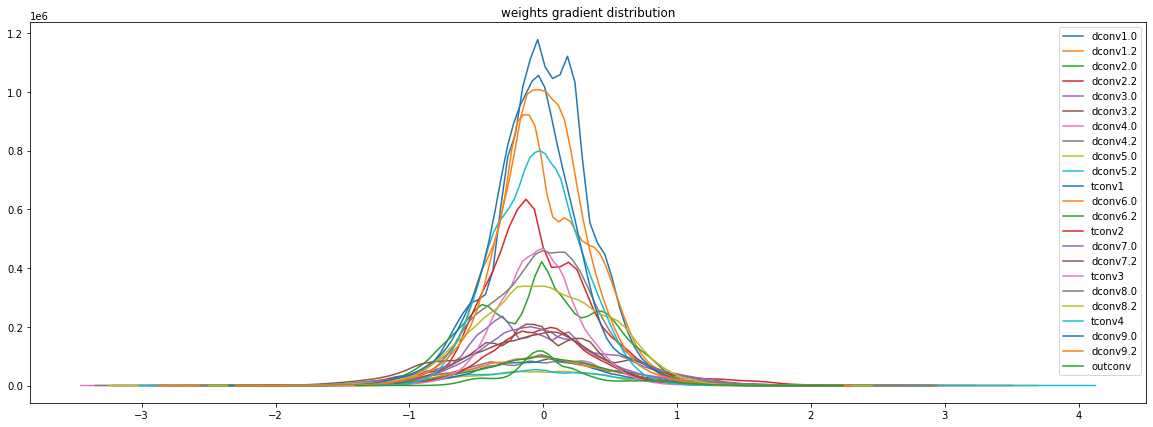

In [35]:
plt.figure(figsize=(20, 7))
model(x);
plt.legend(legends)
plt.title("Preactivations default initialization");

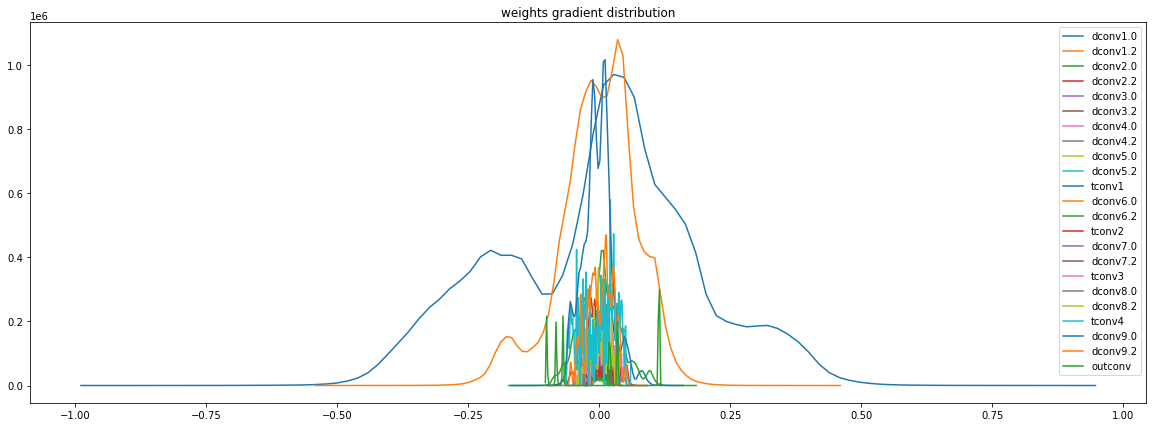

In [27]:
plt.figure(figsize=(20, 7))
kaiming_model(x);
plt.legend(legends)
plt.title("Preactivations kaiming initialization");


In [18]:
def pre_activation_hook(module, inp, out):
    hy, hx = torch.histogram(out.cpu())
    wandb.log({f"preactivations/{module.__name__}": wandb.Histogram(np_histogram=(hy, hx))})


def register_preactivation_hooks(model):
    for name, module in [
        (name, module)
        for name, module in model.named_modules()
        if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d))
    ]:
        module.__name__ = name
        module.register_forward_hook(pre_activation_hook)


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/home/david/miniconda3/envs/kaggle/lib/python3.9/threading.py", line 980, in _bootstrap_inner
